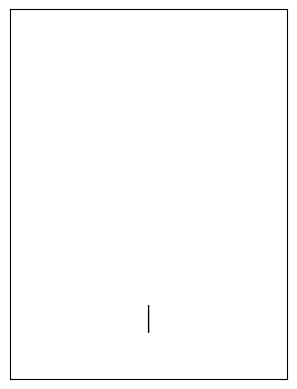

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Wedge

# Define parameters
l = 1  # Length of each segment
frames = 100  # Number of frames in the animation

def get_positions(theta):
    """Compute the (x, y) positions of each joint."""
    x0, y0 = 0, 0
    x1, y1 = x0 - l*np.sin(theta), y0 + l*np.cos(theta)
    x2, y2 = -x1, y1 + l*np.sin(np.arccos(2*np.sin(theta)))
    x3, y3 = 0, y2 + l*np.cos(theta)
    return [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]

def get_positions_part2(theta):
    """Compute the (x, y) positions of each joint."""
    x0, y0 = 0, 0
    x1, y1 = x0 - l*np.sin(theta), y0 + l*np.cos(theta)
    x2, y2 = -x1, y1 - l*np.cos(np.arcsin(2*np.sin(theta)))
    x3, y3 = 0, y2 + l*np.cos(theta)
    return [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]

# Generate angles for the animation
angles_1 = np.linspace(0, np.pi/6, frames//2)
angles_2 = np.linspace(np.pi/6, np.pi/6, frames//4)
angles_3 = np.linspace(np.pi/6, 0, frames//2)
angles_4 = np.linspace(0, 0, frames//4)
angles = np.concatenate((angles_1, angles_2, angles_3, angles_4))  # Full cycle
angles = np.concatenate((angles, angles[::-1]))  # Reverse back to start

# Prepare the figure
fig, ax = plt.subplots()
ax.set_xlim(-1.5 * l, 1.5 * l)
ax.set_ylim(-0.5 * l, 3 * l + 0.5)
ax.set_aspect('equal')

# Remove axis labels and grid lines
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# Initialize the line object
line, = ax.plot([], [], 'o-', lw=2)
guide_line, = ax.plot([], [], 'k-', lw=0.5)
angle_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)
wedge = Wedge((0, 0), 0.3, 90, 90, color='black')  # Rotate 90 degrees counterclockwise
ax.add_patch(wedge)
theta_label = ax.text(0.15, 0.15, '', fontsize=10)

def init():
    """Initialize the animation."""
    line.set_data([], [])
    guide_line.set_data([], [])
    angle_text.set_text('')
    wedge.set_theta1(90)
    wedge.set_theta2(90)
    theta_label.set_text('')
    return line, guide_line, angle_text, wedge, theta_label

def update(frame):
    """Update the animation frame."""
    theta = angles[frame]
    if frame < len(angles)//4 or frame >= 3*len(angles)//4:
        pos = get_positions(theta)
    else:
        pos = get_positions_part2(theta)
    x_vals, y_vals = zip(*pos)
    line.set_data(x_vals, y_vals)
    guide_line.set_data([0, 0], [0, 0.5])
    angle_text.set_text(f'Theta: {np.degrees(theta):.2f}°')
    wedge.set_theta2(90 + np.degrees(theta))  # Adjust for rotation
    if np.isclose(theta, np.pi/6):
        line.set_color('red')
    elif np.isclose(x_vals[2], 0) and np.isclose(y_vals[2], 0):
        line.set_color('green')
    else:
        line.set_color('blue')
    return line, guide_line, angle_text, wedge, theta_label

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(angles), init_func=init, blit=True)
plt.show()
# Save the animation (optional)
ani.save('squat_animation.gif', writer='pillow', fps=20)

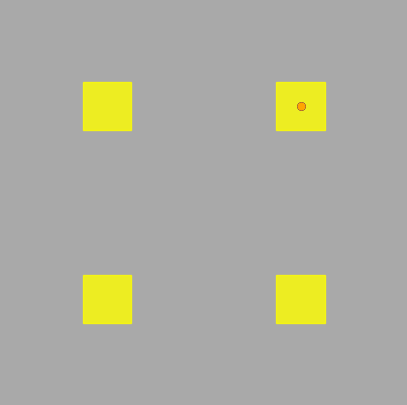

In [11]:
# Adjust Brownian motion to steadily converge toward the destination

# Define a function to generate constrained Brownian motion
def generate_converging_paths(start, end, num_particles, num_steps, noise_scale=0.1):
    """
    Generate paths that follow a Brownian motion but steadily converge toward the end point.
    """
    paths = np.zeros((num_particles, num_steps, 2))
    for i in range(num_particles):
        # Linear trajectory
        trajectory = np.linspace(start, end, num_steps)
        
        # Add constrained Brownian motion with decreasing noise
        noise = np.cumsum(np.random.normal(scale=noise_scale, size=(num_steps, 2)), axis=0)
        
        # Weight noise to be stronger initially and fade as they approach the target
        decay_factor = np.linspace(1.0, 0.2, num_steps).reshape(-1, 1)
        paths[i] = trajectory + noise * decay_factor

    # Ensure all particles end at the target
    paths[:, -1, :] = end
    return paths

# Generate new paths with smoother convergence
paths = generate_converging_paths(start_pos, end_pos, num_particles, num_steps, noise_scale=0.15)

# Define colors for the particles
particle_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Set up the figure and axis with dark grey background
fig, ax = plt.subplots(figsize=(5, 5), facecolor='darkgrey')
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_facecolor('darkgrey')

# Draw smaller yellow location rectangles (shrunk by at least half)
for (x, y) in fixed_points:
    rect = plt.Rectangle((x - 0.25, y - 0.25), 0.5, 0.5, color='yellow', alpha=0.8)
    ax.add_patch(rect)

# Create scatter plots for moving points with different colors
particle_plots = [ax.plot([], [], 'o', color=particle_colors[i], markersize=5)[0] for i in range(num_particles)]

# Animation function
def update(frame):
    for i in range(num_particles):
        particle_plots[i].set_data([paths[i, frame, 0]], [paths[i, frame, 1]])
    return particle_plots

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=50, blit=True)

# Display animation
HTML(ani.to_jshtml())


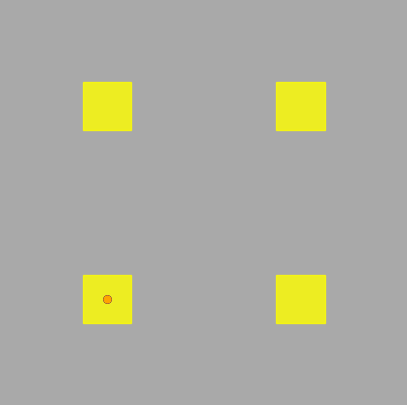

In [15]:
# Modify the animation to loop 4 times, moving to different random locations

# Number of loops (trips between locations)
num_loops = 4

# Generate random sequences of start and end locations
np.random.seed(41)  # For reproducibility
location_sequence = np.random.choice(len(fixed_points), size=num_loops + 1, replace=True)

# Generate paths for each loop
all_paths = []

for i in range(num_loops):
    start_pos = fixed_points[location_sequence[i]]
    end_pos = fixed_points[location_sequence[i + 1]]
    paths = generate_converging_paths(start_pos, end_pos, num_particles, num_steps, noise_scale=0.09)
    all_paths.append(paths)

# Flatten the paths list to create a seamless animation
full_paths = np.concatenate(all_paths, axis=1)

# Extend the number of steps to include pauses at the destination
pause_duration = 15  # Number of frames to pause at each stop
extended_paths = []

for i in range(num_loops):
    extended_paths.append(all_paths[i])
    # Append the last position multiple times to create a pause effect
    pause_frames = np.repeat(all_paths[i][:, -1:, :], pause_duration, axis=1)
    extended_paths.append(pause_frames)

# Concatenate all segments
final_paths = np.concatenate(extended_paths, axis=1)

# Adjust the total number of frames for animation
total_frames = final_paths.shape[1]

# Set up the figure and axis with dark grey background
fig, ax = plt.subplots(figsize=(5, 5), facecolor='darkgrey')
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_facecolor('darkgrey')

# Draw smaller yellow location rectangles
for (x, y) in fixed_points:
    rect = plt.Rectangle((x - 0.25, y - 0.25), 0.5, 0.5, color='yellow', alpha=0.8)
    ax.add_patch(rect)

# Create scatter plots for moving points with different colors
particle_plots = [ax.plot([], [], 'o', color=particle_colors[i], markersize=5)[0] for i in range(num_particles)]

# Animation function
def update(frame):
    for i in range(num_particles):
        particle_plots[i].set_data([final_paths[i, frame, 0]], [final_paths[i, frame, 1]])
    return particle_plots

# Create animation
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=50, blit=True)

# Save the animation as a GIF
ani.save('converging_paths_animation.gif', writer='pillow', fps=20)

# Display animation
HTML(ani.to_jshtml())
